# Machine Learning in Business Analytics Project: Cocktail Recommandation (Alexander Liden & Samy Maurer)

## Import the libraries

In [57]:
from bs4 import BeautifulSoup
import requests
import warnings
import pandas as pd #needs version < 2.0 to work
import csv
import time
import concurrent.futures
from tabulate import tabulate
import numpy
import unicodedata
import re
import fractions
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import backend as K
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance
from tensorflow.keras.utils import plot_model

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


In [58]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


## Scraping Algorithm

In [59]:
baseurl = "https://www.diffordsguide.com/cocktails/recipe/" # then: {NUMBER}/index.html"
basedata = {
    'Name': [],
    'Glass': [],
    'Garnish': [],
    'How to make': [],
    'Contents': [],
    'Ratios': [],
    'Gentle / Boozy': [],
    'Sweet / Dry Sour': [],
    'Calories': [],
    'Calories2': [],
    'Alcohol percentage': [],
    'Alcohol percentage2': [],
    #'User Rating': [],
    'Popularity': [],
    #'Difford Rating': [],
    'Category': [],
    'URL': []
}
cocktail_df = pd.DataFrame()


In [60]:
"""Initialize the scraping process"""
status = "DONE"

if status == "DONE":
    print("Scrape already done, please continue")
else:
    print("Scrape has not been initiated, let's begin")
    current_url = ""
    page = ""
    soup_cocktail = ""
    testlist = []
    starttime = time.time()
    """Loop to get the information"""
    for i in range(0, 6572): #put 6572 when testing ok; will take approx. 9h to complete with 5s delay each :)
        img_tag = ""
        img_tag2 = ""
        current_url = "{}{}/index.html".format(baseurl, i)
        page = requests.get(current_url)
        print("Current URL is: ", current_url)
        basedata['URL'] = current_url

        soup_cocktail = BeautifulSoup(page.content, "html.parser")

        basedata['Name'] = soup_cocktail.select_one('h1')
        if basedata['Name']:
            basedata['Name'] = basedata['Name'].text.strip()
        else:
            basedata['Name'] = ""
        print(basedata['Name'])

        basedata['Glass'] = soup_cocktail.select_one('#sticky-anchor > div > div > div.cell.auto.divide-right-large > div > article > div > div:nth-child(2) > a')
        if basedata['Glass']:
            basedata['Glass'] = basedata['Glass'].text.strip()
        else:
            basedata['Glass'] = ""

        basedata['Garnish'] = soup_cocktail.select_one('#sticky-anchor > div > div > div.cell.auto.divide-right-large > div > article > div > div:nth-child(3) > p')
        if basedata['Garnish']:
            basedata['Garnish'] = basedata['Garnish'].text.split()
        else:
            basedata['Garnish'] = []

        basedata['How to make'] = soup_cocktail.select_one('#sticky-anchor > div > div > div.cell.auto.divide-right-large > div > article > div > div:nth-child(4) > p')
        if basedata['How to make']:
            basedata['How to make'] = basedata['How to make'].text.strip()
        else:
            basedata['How to make'] = ""

        basedata['Calories'] = soup_cocktail.select_one('#sticky-anchor > div > div > div.cell.auto.divide-right-large > div > article > div > div:nth-child(13) > p > strong')
        if basedata['Calories']:
            basedata['Calories'] = basedata['Calories'].text.strip()
        else:
            basedata['Calories'] = ""
        
        basedata['Calories2'] = soup_cocktail.select_one('#sticky-anchor > div > div > div.cell.auto.divide-right-large > div > article > div > div:nth-child(12) > p > strong')
        if basedata['Calories2']:
            basedata['Calories2'] = basedata['Calories2'].text.strip()
        else:
            basedata['Calories2'] = ""

        basedata['Alcohol percentage'] = soup_cocktail.select_one('#sticky-anchor > div > div > div.cell.auto.divide-right-large > div > article > div > div:nth-child(14) > ul > li:nth-child(2)')
        if basedata['Alcohol percentage']:
            basedata['Alcohol percentage'] = basedata['Alcohol percentage'].text.split("%")[0].strip()
        else:
            basedata['Alcohol percentage'] = ""

        basedata['Alcohol percentage2'] = soup_cocktail.select_one('#sticky-anchor > div > div > div.cell.auto.divide-right-large > div > article > div > div:nth-child(13) > ul > li:nth-child(2)')
        if basedata['Alcohol percentage2']:
            basedata['Alcohol percentage2'] = basedata['Alcohol percentage2'].text.split("%")[0].strip()
        else:
            basedata['Alcohol percentage2'] = ""

        basedata['Popularity'] = soup_cocktail.select_one('body > div.grid-x.grid-margin-y > div.cell.main-content > div.strip.strip--content.bg-cocktails-tone.strip--notch > div > div > div:nth-child(2) > div > div.cell.small-12.medium-shrink > div > div.cell.shrink.alt-font.text-small.always-first-small.no-wrap > span')
        if basedata['Popularity']:
            basedata['Popularity'] = basedata['Popularity'].text.split()[0].split('(')[1].strip()
        else:
            basedata['Popularity'] = ""

        basedata['Category'] = soup_cocktail.select_one('#sticky-anchor > div > div > div.cell.auto.divide-right-large > div > article > div > div.cell.hide-for-large > p > a:nth-child(1) > strong')
        if basedata['Category']:
            basedata['Category'] = basedata['Category'].text.strip()
        else:
            basedata['Category'] = ""

        basedata['Contents'] = [el.text.strip() for el in soup_cocktail.select('#sticky-anchor > div > div > div.cell.auto.divide-right-large > div > article > div > div:nth-child(5) > table > tbody td:nth-of-type(2)')]
        if not basedata['Contents']:
            basedata['Contents'] = []
        
        if soup_cocktail.select('#sticky-anchor > div > div > div.cell.auto.divide-right-large > div > article > div > div:nth-child(5) > table > tbody td:nth-of-type(1)'):
            basedata['Ratios'] = [el.text.strip() for el in soup_cocktail.select('#sticky-anchor > div > div > div.cell.auto.divide-right-large > div > article > div > div:nth-child(5) > table > tbody td:nth-of-type(1)')]
        else:
            basedata['Ratios'] = ""

        basedata['Sweet / Dry Sour'] = soup_cocktail.select_one('#sticky-anchor > div > div > div.cell.auto.divide-right-large > div > article > div > div:nth-child(9) > div > div:nth-child(2) > div > div > div:nth-child(3) > img')
        if basedata['Sweet / Dry Sour']:
            basedata['Sweet / Dry Sour'] = basedata['Sweet / Dry Sour']["alt"].strip()
        else:
            basedata['Sweet / Dry Sour'] = ""
        
        basedata['Gentle / Boozy'] = soup_cocktail.select_one('#sticky-anchor > div > div > div.cell.auto.divide-right-large > div > article > div > div:nth-child(9) > div > div:nth-child(1) > div > div > div:nth-child(3) > img')
        if basedata['Gentle / Boozy']:
            basedata['Gentle / Boozy'] = basedata['Gentle / Boozy']["alt"].strip()
        else:
            basedata['Gentle / Boozy'] = ""
            
        cocktail_df = cocktail_df.append(basedata, ignore_index=True)
        cocktail_df.to_csv("out_temp.csv", index=False, encoding='utf-8') #temp csv in case we get kicked out of the site
        print(" ")
        #Sleep is important not to get kicked out
        time.sleep(5)    
        
        #Erases the last glitched item in the Ratios column
    cocktail_df['Ratios'] = cocktail_df['Ratios'].apply(lambda x: x[:-1] if (x is not None and x) else x)
    cocktail_df.to_csv("out_fin.csv", index=False, encoding='utf-8')
    cocktail_df.to_pickle("out_fin.pkl")
    cocktail_df[-20:]

    endtime = time.time()
    print("Finished in {i:.2f} seconds!".format(i = endtime - starttime))

Scrape already done, please continue


You will notice that we created 2 columns for "Calories". This emanes from the fact that some cocktails have a "AKA" section, so the selector doesn't work anymore.
To prevent this, we created this temporary, ugly, solution.

In [61]:
df = pd.read_csv("out_fin.csv")
df.head()

,Name,Glass,Garnish,How to make,Contents,Ratios,Gentle / Boozy,Sweet / Dry Sour,Calories,Calories2,Alcohol percentage,Alcohol percentage2,Popularity,Category,URL
0,404 - Page not found,NaN,[],NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.diffordsguide.com/cocktails/recipe...
1,Abacaxi Ricaço,Pineapple shell (frozen) glass,"['Cut', 'a', 'straw', 'sized', 'hole', 'in', '...",Cut the top off a small pineapple and carefull...,"['Pineapple (fresh)', 'Gold rum (1-3 years old...","['1 whole', '3 shot', '3⁄4 shot', '1⁄2 shot']",NaN,NaN,NaN,NaN,NaN,25.67,6.0,Frozen (blended),https://www.diffordsguide.com/cocktails/recipe...
2,404 - Page not found,NaN,[],NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.diffordsguide.com/cocktails/recipe...
3,Abbey,Coupe glass,"['Orange', 'zest', 'twist']",SHAKE all ingredients with ice and fine strain...,"['Rutte Dry Gin', 'Lillet Blanc (or other arom...","['1 1⁄2 shot', '3⁄4 shot', '3⁄4 shot', '2 dash']",7.0,7.0,NaN,133 calories,NaN,20.97,27.0,Classic/vintage,https://www.diffordsguide.com/cocktails/recipe...
4,A.B.C. Cocktail,Nick & Nora glass,"['Lemon', 'zest', 'twist', '&', 'Luxardo', 'Ma...",SHAKE all ingredients with ice and fine strain...,"['Mint leaves', 'Tawny port', 'Rémy Martin 173...","['7 fresh', '1 shot', '1 shot', '1⁄4 shot', '1...",7.0,5.0,NaN,NaN,NaN,NaN,11.0,Classic/vintage,https://www.diffordsguide.com/cocktails/recipe...


## Cleaning

Now that we have the file, let's clean the data

In [62]:
# Merge the "Alcohol percentage" and "Alcohol percentage2" columns
df['Alcohol percentage'] = df['Alcohol percentage'].fillna(df['Alcohol percentage2'])

# Merge the "Calories" and "Calories2" columns
df['Calories'] = df['Calories'].fillna(df['Calories2'])

# Drop the extra columns & the ones we don't need
df = df.drop(columns=['Alcohol percentage2', 'Calories2', 'Garnish', 'URL'])

# Delete rows where the name is "404 - Page not found"
df = df[df['Name'] != '404 - Page not found']

# Drop rows where "Gentle / Boozy", "Sweet / Dry Sour", "Alcohol percentage", and "Category" columns have NaN values.
# Dilemma: we can't use alcohol percentage because it reduces our dataset by 400. The category is responsible for 300 cocktails, and calories for 1000...
# if we keep them, we have 2400. if not, we have 1200.
df = df.dropna(subset=['Gentle / Boozy', 'Sweet / Dry Sour', 'Calories', 'Alcohol percentage', "Category"])


df.head()

,Name,Glass,How to make,Contents,Ratios,Gentle / Boozy,Sweet / Dry Sour,Calories,Alcohol percentage,Popularity,Category
3,Abbey,Coupe glass,SHAKE all ingredients with ice and fine strain...,"['Rutte Dry Gin', 'Lillet Blanc (or other arom...","['1 1⁄2 shot', '3⁄4 shot', '3⁄4 shot', '2 dash']",7.0,7.0,133 calories,20.97,27.0,Classic/vintage
7,Absinthe Sour,Old-fashioned glass,SHAKE all ingredients with ice and strain back...,"['La Fée Parisienne absinthe', ""Sugar syrup 'r...","['5⁄6 shot', '1⁄3 shot', '1⁄2 shot', '1⁄2 shot...",7.0,6.0,142 calories,21.2,16.0,Classic/vintage
10,Absolutely Fabulous,Flute glass,SHAKE first two ingredients with ice and strai...,"['Ketel One Vodka', 'Cranberry juice (sweetene...","['1 shot', '1 1⁄2 shot', '1 1⁄2 shot']",6.0,6.0,117 calories,11.69,9.0,Champagne
14,Ace Of Clubs Daiquiri,Coupe glass,SHAKE all ingredients with ice and fine strain...,"['Gold rum (1-3 years old mellow light)', 'Dut...","['2 shot', '1⁄2 shot', '1⁄2 shot', '1⁄6 shot']",7.0,6.0,190 calories,23.43,27.0,Classic/vintage
15,Achilles Heel,Collins glass,SHAKE all ingredients with ice and strain into...,"['Bison grass vodka', 'Giffard Framboise de Ro...","['2 shot', '1⁄4 shot', '1⁄4 shot', '2 shot', '...",6.0,6.0,212 calories,14.44,13.0,Long drinks & highballs


In [63]:
print(len(df))
print(numpy.unique(df['Popularity'].isna())) #this means that some cocktails have 0 reviews, that's ok


1208
[False  True]


In [64]:
# Function to convert string fractions to decimal numbers
def fraction_to_decimal(fraction_str):
    # Replace special fraction character with a regular slash
    fraction_str = fraction_str.replace('⁄', '/')
    
    # Check for mixed numbers (e.g., "1 1/2")
    mixed_number_regex = re.compile(r'(\d+)\s+(\d+)/(\d+)')
    match = mixed_number_regex.match(fraction_str.strip())  # Use strip() to remove extra spaces

    if match:
        whole = int(match.group(1))
        num = int(match.group(2))
        denom = int(match.group(3))
        frac = fractions.Fraction(num, denom)
        return float(whole) + float(frac)
    else:
        try:
            return float(fraction_str)
        except ValueError:
            frac = fractions.Fraction(fraction_str)
            return float(frac)

# Test the function with the mixed number "1 1⁄2"
fraction_str = "1 1⁄2"
print(fraction_to_decimal(fraction_str))  # Output: 1.5

1.5


In [65]:
def extract_methods(how_to_make):
    """
    Extract all-caps words from the 'how_to_make' string.
    
    :param how_to_make: The 'how_to_make' string
    :return: A list of all-caps words
    """
    words = how_to_make.split()
    methods = [word for word in words if word.isupper()]
    return methods


# Extract unique methods from the 'How to make' column
unique_methods = set()
for index, row in df.iterrows():
    methods = extract_methods(row['How to make'])
    unique_methods.update(methods)

# Create a new column for each unique method
for method in unique_methods:
    column_name = f"Method_{method}"
    df[column_name] = df['How to make'].apply(lambda x: method in x)

# Display the DataFrame
df.head()


,Name,Glass,How to make,Contents,Ratios,Gentle / Boozy,Sweet / Dry Sour,Calories,Alcohol percentage,Popularity,...,Method_POURING,Method_PX,Method_OR,Method_DRY,Method_FLASH-BLEND,Method_STRAIN,Method_FILL,Method_LAYER,Method_THROW,Method_RINSE
3,Abbey,Coupe glass,SHAKE all ingredients with ice and fine strain...,"['Rutte Dry Gin', 'Lillet Blanc (or other arom...","['1 1⁄2 shot', '3⁄4 shot', '3⁄4 shot', '2 dash']",7.0,7.0,133 calories,20.97,27.0,...,False,False,False,False,False,False,False,False,False,False
7,Absinthe Sour,Old-fashioned glass,SHAKE all ingredients with ice and strain back...,"['La Fée Parisienne absinthe', ""Sugar syrup 'r...","['5⁄6 shot', '1⁄3 shot', '1⁄2 shot', '1⁄2 shot...",7.0,6.0,142 calories,21.2,16.0,...,False,False,False,True,False,False,False,False,False,False
10,Absolutely Fabulous,Flute glass,SHAKE first two ingredients with ice and strai...,"['Ketel One Vodka', 'Cranberry juice (sweetene...","['1 shot', '1 1⁄2 shot', '1 1⁄2 shot']",6.0,6.0,117 calories,11.69,9.0,...,False,False,False,False,False,False,False,False,False,False
14,Ace Of Clubs Daiquiri,Coupe glass,SHAKE all ingredients with ice and fine strain...,"['Gold rum (1-3 years old mellow light)', 'Dut...","['2 shot', '1⁄2 shot', '1⁄2 shot', '1⁄6 shot']",7.0,6.0,190 calories,23.43,27.0,...,False,False,False,False,False,False,False,False,False,False
15,Achilles Heel,Collins glass,SHAKE all ingredients with ice and strain into...,"['Bison grass vodka', 'Giffard Framboise de Ro...","['2 shot', '1⁄4 shot', '1⁄4 shot', '2 shot', '...",6.0,6.0,212 calories,14.44,13.0,...,False,False,False,False,False,False,False,False,False,False


In [66]:
# Iterate through the "Contents" and "Ratios" columns
# For each row in the DataFrame

def find_all_caps_words(text):
    return re.findall(r'\b[A-Z]+\b', text)

for index, row in df.iterrows():
    # Get the contents and ratios as lists
    contents = eval(row['Contents'])
    ratios = eval(row['Ratios'])

    # Iterate through the contents and ratios
    for content, ratio in zip(contents, ratios):
        # Split the ratio into amount and unit (e.g., "1 1/2 shot" => "1", "1/2", "shot")
        ratio_parts = ratio.split()

        if len(ratio_parts) == 3:
            whole, fraction, unit = ratio_parts
            decimal_fraction = fraction_to_decimal(fraction)  # Convert the fraction part to a decimal
            amount = float(whole) + decimal_fraction
            ratio = f"{amount} {unit}"
            
        elif len(ratio_parts) == 2:
            amount, unit = ratio_parts
            amount = fraction_to_decimal(amount)  # Convert the amount to a decimal
            ratio = f"{amount} {unit}"
        
        # Create new columns for each content with the corresponding ratio value
        content_column = f"Content_{content}"
        ratio_column = f"Ratio_{content}"
        df.loc[index, content_column] = True
        df.loc[index, ratio_column] = ratio

unique_methods = set()
for index, row in df.iterrows():
    methods = extract_methods(row['How to make'])
    unique_methods.update(methods)

# Create a new column for each unique method
for method in unique_methods:
    column_name = f"Method_{method}"
    df[column_name] = df['How to make'].apply(lambda x: method in x)

# Create one new column per category with boolean values
category_dummies = pd.get_dummies(df['Category'], prefix='Category')
df = pd.concat([df, category_dummies], axis=1)

# Let's do the same with the glasses
glass_dummies = pd.get_dummies(df['Glass'], prefix='Glass')
df = pd.concat([df, glass_dummies], axis=1)

# filter out rows that don't match expected format
df = df[df['Calories'].str.match('\d+\s+calories')]

# extract numbers using split method and create a new column
df['Calories'] = df['Calories'].apply(lambda x: int(x.split()[0]))
df['Calories'] = df['Calories'].astype(int)

#Transforms the alcohol percentage to float
df['Alcohol percentage'] = df['Alcohol percentage'].astype(float)

# Find the columns that start with 'METHOD_'
method_columns = [col for col in df.columns if col.startswith('Method_')]

# Convert boolean values to 1s and 0s
df[method_columns] = df[method_columns].astype(int)

In [67]:
df.head()


,Name,Glass,How to make,Contents,Ratios,Gentle / Boozy,Sweet / Dry Sour,Calories,Alcohol percentage,Popularity,...,Glass_Nick & Nora glass,Glass_Old-fashioned glass,Glass_Rocks glass,Glass_Shot and Beer glass,Glass_Shot glass,Glass_Sling glass,Glass_Snifter glass,Glass_Tiki mug or collins,Glass_Toddy glass,Glass_Wine glass
3,Abbey,Coupe glass,SHAKE all ingredients with ice and fine strain...,"['Rutte Dry Gin', 'Lillet Blanc (or other arom...","['1 1⁄2 shot', '3⁄4 shot', '3⁄4 shot', '2 dash']",7.0,7.0,133,20.97,27.0,...,0,0,0,0,0,0,0,0,0,0
7,Absinthe Sour,Old-fashioned glass,SHAKE all ingredients with ice and strain back...,"['La Fée Parisienne absinthe', ""Sugar syrup 'r...","['5⁄6 shot', '1⁄3 shot', '1⁄2 shot', '1⁄2 shot...",7.0,6.0,142,21.20,16.0,...,0,1,0,0,0,0,0,0,0,0
10,Absolutely Fabulous,Flute glass,SHAKE first two ingredients with ice and strai...,"['Ketel One Vodka', 'Cranberry juice (sweetene...","['1 shot', '1 1⁄2 shot', '1 1⁄2 shot']",6.0,6.0,117,11.69,9.0,...,0,0,0,0,0,0,0,0,0,0
14,Ace Of Clubs Daiquiri,Coupe glass,SHAKE all ingredients with ice and fine strain...,"['Gold rum (1-3 years old mellow light)', 'Dut...","['2 shot', '1⁄2 shot', '1⁄2 shot', '1⁄6 shot']",7.0,6.0,190,23.43,27.0,...,0,0,0,0,0,0,0,0,0,0
15,Achilles Heel,Collins glass,SHAKE all ingredients with ice and strain into...,"['Bison grass vodka', 'Giffard Framboise de Ro...","['2 shot', '1⁄4 shot', '1⁄4 shot', '2 shot', '...",6.0,6.0,212,14.44,13.0,...,0,0,0,0,0,0,0,0,0,0


## EDA

In [68]:
df['Popularity'] = df['Popularity'].fillna(0)
df.describe()

,Gentle / Boozy,Sweet / Dry Sour,Calories,Alcohol percentage,Popularity,Method_DISCARD.,Method_POUR,Method_MUDDLE,Method_STIR,Method_(BEWARE,...,Glass_Nick & Nora glass,Glass_Old-fashioned glass,Glass_Rocks glass,Glass_Shot and Beer glass,Glass_Shot glass,Glass_Sling glass,Glass_Snifter glass,Glass_Tiki mug or collins,Glass_Toddy glass,Glass_Wine glass
count,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,...,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000
mean,6.957746,6.304888,179.140845,21.352345,26.459818,0.000829,0.072080,0.000829,0.389395,0.000829,...,0.081193,0.183927,0.001657,0.000829,0.002486,0.005800,0.000829,0.006628,0.000829,0.003314
std,1.503684,1.142355,65.955272,6.403123,38.817661,0.028784,0.258727,0.028784,0.487815,0.028784,...,0.273245,0.387585,0.040689,0.028784,0.049813,0.075965,0.028784,0.081176,0.028784,0.057496
min,0.000000,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,6.000000,154.500000,16.770000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,6.000000,175.000000,21.220000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.000000,7.000000,200.000000,26.320000,30.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,10.000000,1975.000000,42.370000,681.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Correlations: Check for correlations between numerical columns like alcohol percentage and calories.

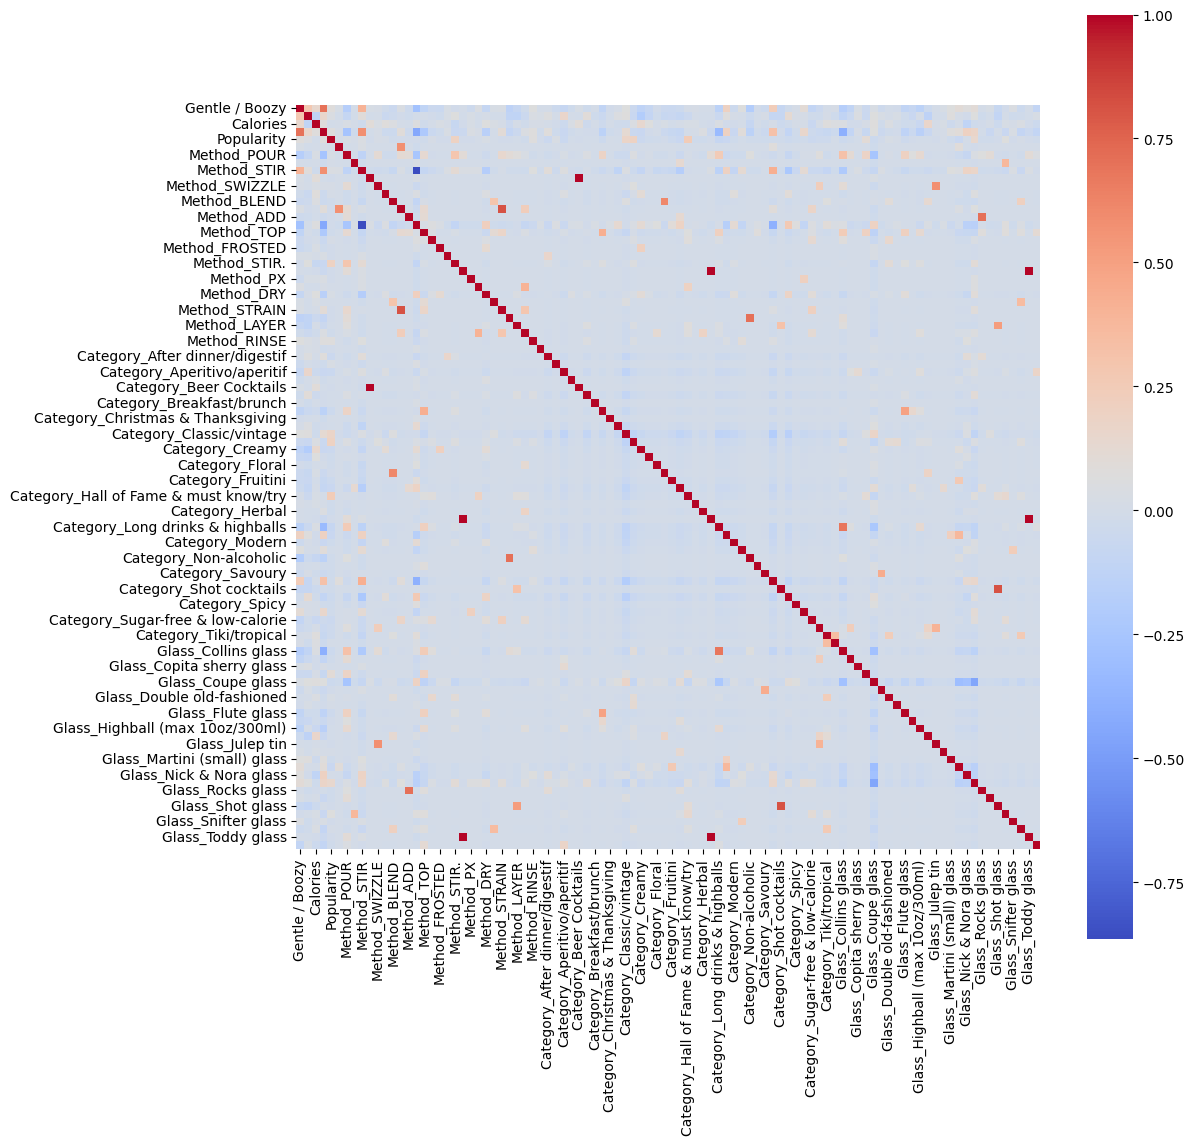

In [69]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", square=True)
plt.show()

Top 20 correlated attribute pairs:
Method_STIR                       Method_SHAKE              -0.863537
Method_STRAIN                     Method_DISCARD             0.816158
Glass_Shot glass                  Category_Shot cocktails    0.816158
Glass_Rocks glass                 Method_ADD                 0.706814
Method_FILL                       Category_Non-alcoholic     0.706814
Gentle / Boozy                    Alcohol percentage         0.695940
Category_Long drinks & highballs  Glass_Collins glass        0.685136
Category_Frozen (blended)         Method_BLEND               0.613045
Method_STIR                       Alcohol percentage         0.583940
Glass_Julep tin                   Method_SWIZZLE             0.576871
Method_DISCARD.                   Method_DISCARD             0.576871
Method_LAYER                      Glass_Shot glass           0.514896
Glass_Flute glass                 Category_Champagne         0.494222
Glass_Old-fashioned glass         Glass_Coupe glass    

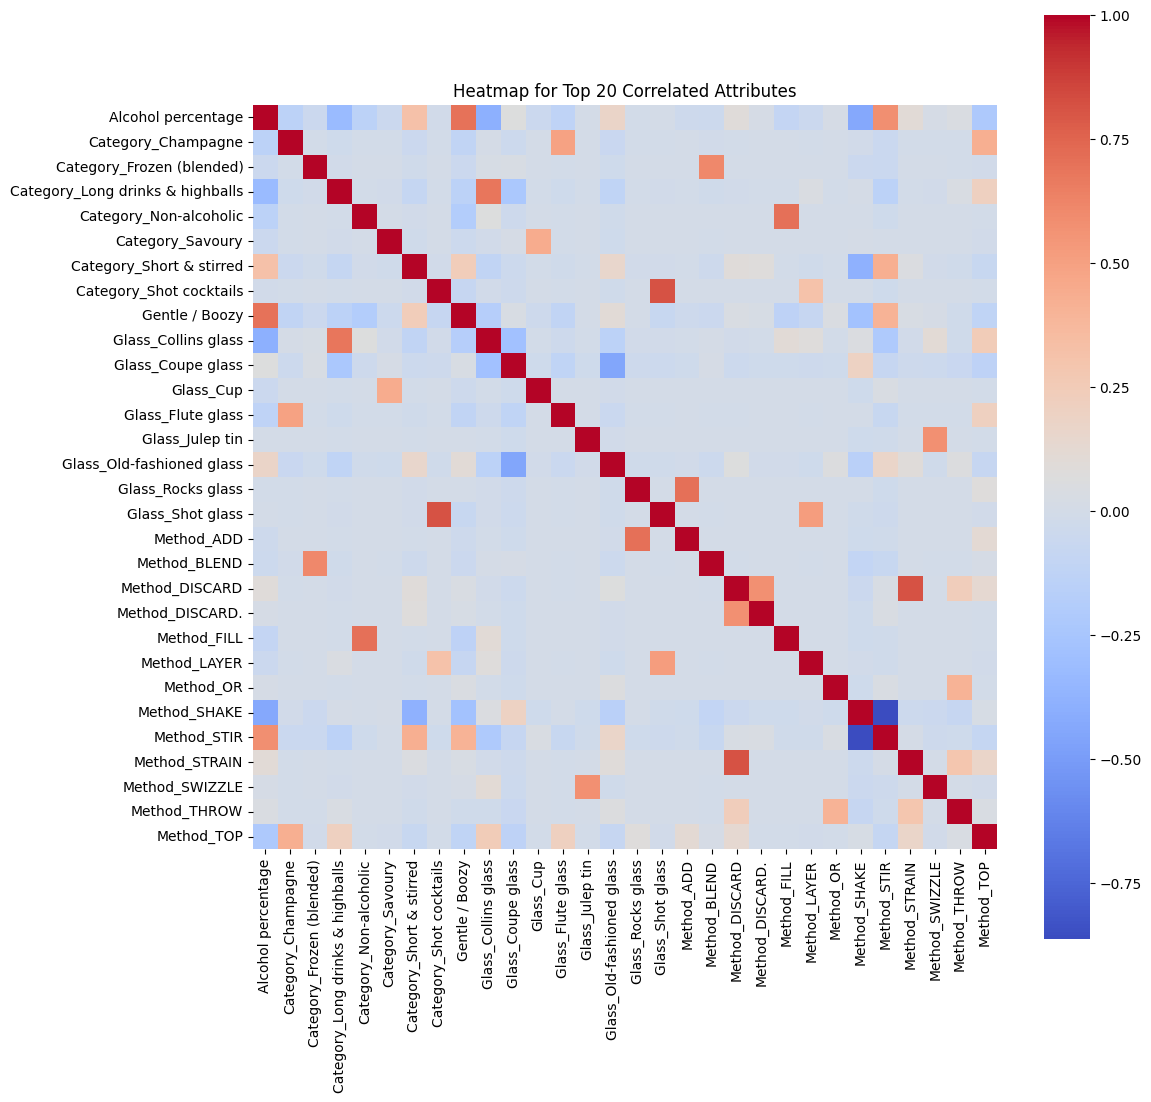

In [70]:
def get_top_correlations(correlation_matrix, n=20):
    """
    Get the top n correlated attribute pairs from the correlation matrix.
    
    :param correlation_matrix: The correlation matrix
    :param n: The number of top correlated pairs to return
    :return: A sorted DataFrame with attribute pairs and their correlations
    """
    attribute_pairs = correlation_matrix.unstack().sort_values(kind="quicksort", key=lambda x: abs(x), ascending=False)
    attribute_pairs = attribute_pairs[attribute_pairs != 1]  # Remove self-correlations (correlation of 1)
    attribute_pairs = attribute_pairs.drop_duplicates()
    return attribute_pairs.head(n)

def get_top_correlated_attributes(correlation_matrix, n=20):
    """
    Get the top n correlated attributes from the correlation matrix.
    
    :param correlation_matrix: The correlation matrix
    :param n: The number of top correlated pairs to consider
    :return: A sorted set of attributes from the top correlated pairs
    """
    top_correlations = get_top_correlations(correlation_matrix, n)
    attributes = set()
    for pair in top_correlations.index:
        attributes.add(pair[0])
        attributes.add(pair[1])
    return sorted(attributes)

correlation_matrix = df.corr()

# Get the top 20 correlated attribute pairs and their attributes
top_attributes = get_top_correlated_attributes(correlation_matrix, 20)
top_correlations = get_top_correlations(correlation_matrix, 20)

# Create a new correlation matrix using only the top correlated attributes
top_correlation_matrix = df[top_attributes].corr()

# Display the top correlated attribute pairs
print("Top 20 correlated attribute pairs:")
print(top_correlations)

# Plot the heatmap for the top correlated attributes
plt.figure(figsize=(12, 12))
sns.heatmap(top_correlation_matrix, annot=False, cmap="coolwarm", square=True)
plt.title("Heatmap for Top 20 Correlated Attributes")
plt.show()

Category distribution: Visualize the distribution of cocktail categories.


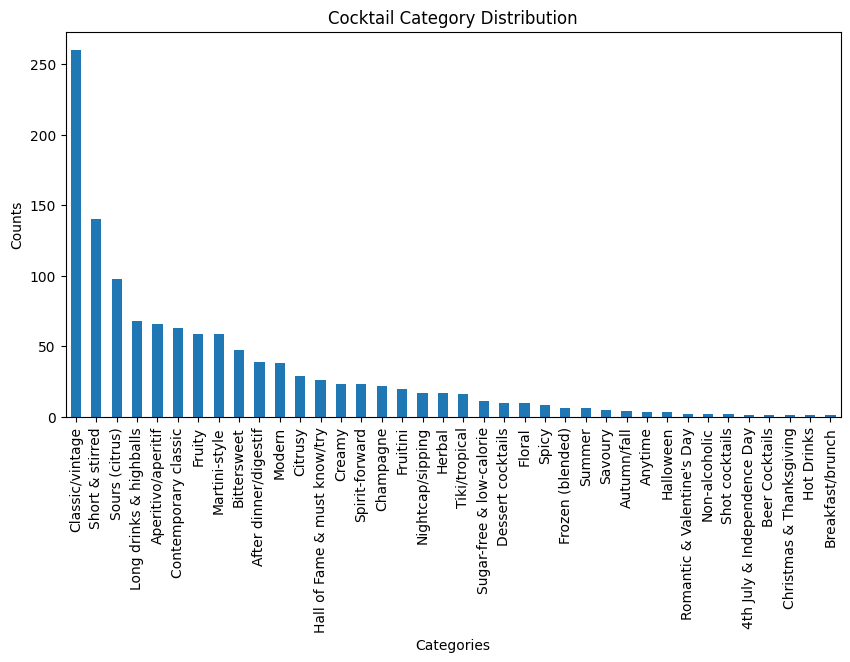

In [71]:
category_counts = df['Category'].value_counts()

plt.figure(figsize=(10, 5))
category_counts.plot(kind='bar')
plt.title("Cocktail Category Distribution")
plt.xlabel("Categories")
plt.ylabel("Counts")
plt.show()

Method distribution: Visualize the distribution of cocktail methods (e.g., SHAKE, STIR).

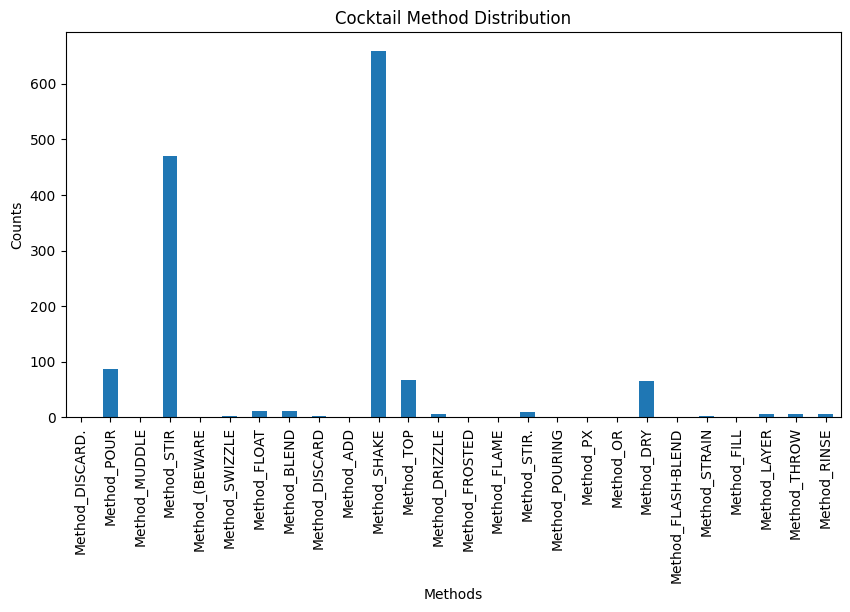

In [72]:
method_columns = [col for col in df.columns if col.startswith('Method_')]
method_counts = df[method_columns].sum()

plt.figure(figsize=(10, 5))
method_counts.plot(kind='bar')
plt.title("Cocktail Method Distribution")
plt.xlabel("Methods")
plt.ylabel("Counts")
plt.show()

Most common ingredients: Find the most common ingredients and visualize their frequency.

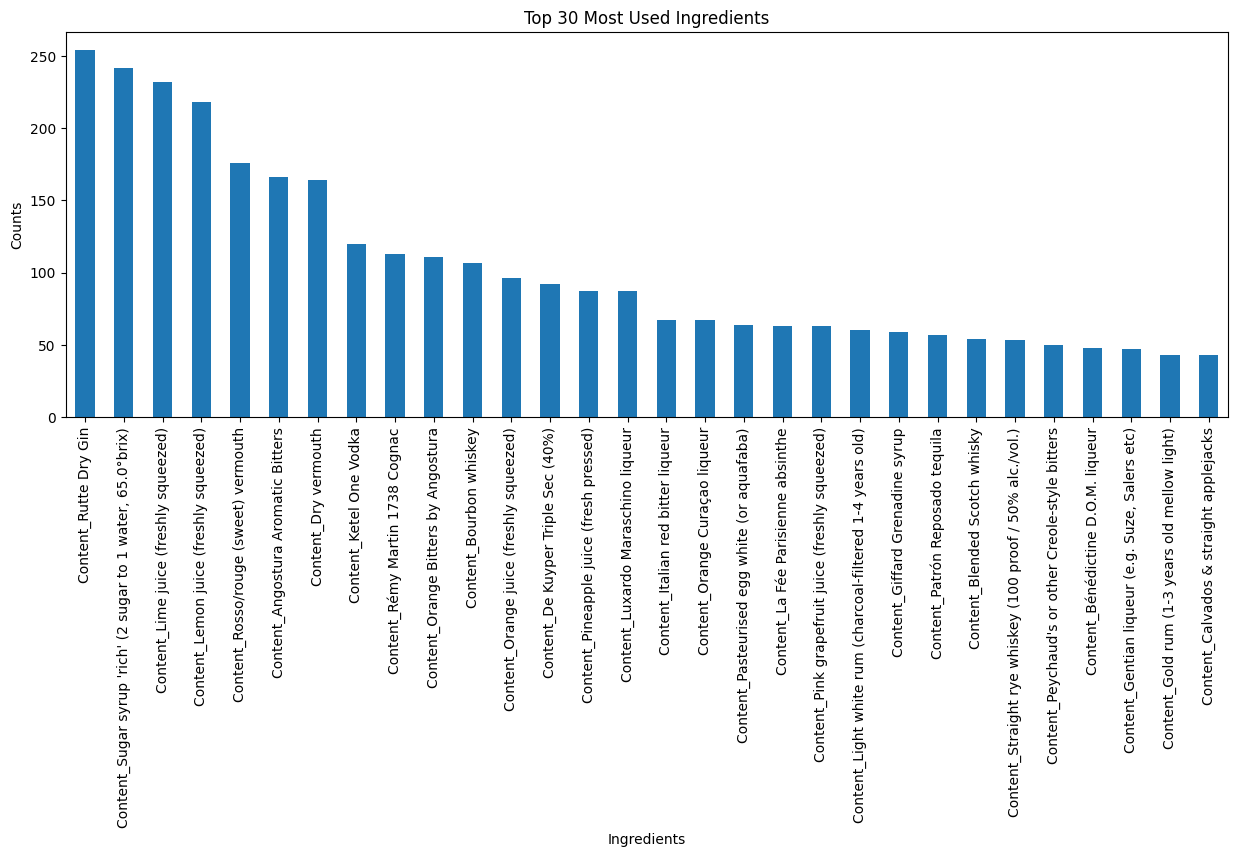

In [73]:
ingredient_columns = [col for col in df.columns if col.startswith('Content_')]
ingredient_counts = df[ingredient_columns].sum()

# Convert ingredient_counts to numeric values
ingredient_counts = pd.to_numeric(ingredient_counts, errors='coerce')

plt.figure(figsize=(15, 5))
ingredient_counts.nlargest(30).plot(kind='bar')
plt.title("Top 30 Most Used Ingredients")
plt.xlabel("Ingredients")
plt.ylabel("Counts")
plt.xticks(rotation=90)
plt.show()


Most common values for the 'Gentle / Boozy', 'Sweet / Dry Sour' columns

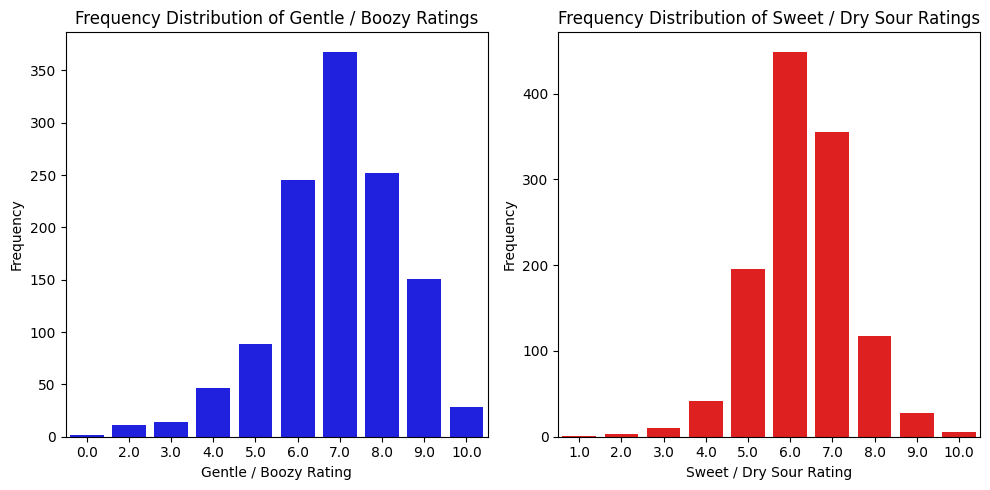

In [74]:
gentle_boozy_counts = df['Gentle / Boozy'].value_counts().sort_index()
sweet_dry_sour_counts = df['Sweet / Dry Sour'].value_counts().sort_index()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=gentle_boozy_counts.index, y=gentle_boozy_counts.values, color='b')
plt.title('Frequency Distribution of Gentle / Boozy Ratings')
plt.xlabel('Gentle / Boozy Rating')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.barplot(x=sweet_dry_sour_counts.index, y=sweet_dry_sour_counts.values, color='r')
plt.title('Frequency Distribution of Sweet / Dry Sour Ratings')
plt.xlabel('Sweet / Dry Sour Rating')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

We can see that the frequency of the gentle / boozy dimensions resembles a normal distribution skewed towards the boozy instead of the gentle. 
Regarding the sweet / dry sour ratings, there are way more cocktails in the middle (425 vs 360) and is less skewed towards the dry sour region than sweet. We'll have to keep this in mind when building our models to avoid false positives / negatives.

Now let's look at the scatterplot:

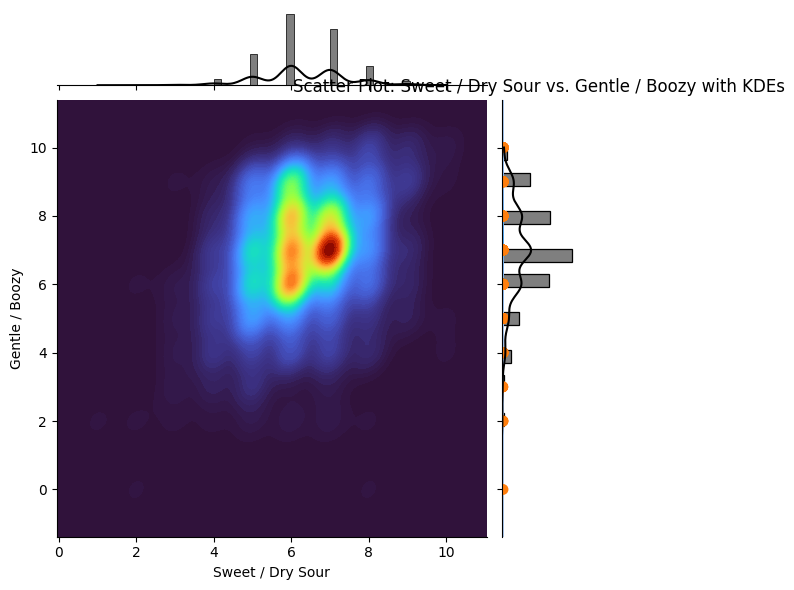

In [75]:
# Create a scatter plot of Sweet / Dry Sour vs. Gentle / Boozy with KDEs
g = sns.JointGrid(data=df, x='Sweet / Dry Sour', y='Gentle / Boozy')
g.plot_joint(sns.kdeplot, fill=True, cmap='turbo', thresh=0, levels=100)
g.plot_marginals(sns.histplot, kde=True, color='black')

# Set the colormap for the scatter plot
cmap = plt.get_cmap('turbo')

# Color the scatter plot points according to the density of points in each region
sns.kdeplot(data=df, x='Sweet / Dry Sour', y='Gentle / Boozy', levels=100, fill=True, thresh=0)
sns.scatterplot(data=df, x='Sweet / Dry Sour', y='Gentle / Boozy', edgecolor='none', s=60)

# Set plot title and labels
plt.title("Scatter Plot: Sweet / Dry Sour vs. Gentle / Boozy with KDEs")
plt.xlabel("Sweet / Dry Sour")
plt.ylabel("Gentle / Boozy")

# Show the plot
plt.show()

The first assumption is revealed here too:the data is biased towards dry/sour and gentle/boozy instead of being centered in the middle

In [76]:
# Extract columns that start with 'Content_'
content_columns = [col for col in df.columns if col.startswith('Content_')]

# Fill NaN values with 0
df[content_columns] = df[content_columns].fillna(0)

# Convert the boolean values in the alcohol dummy columns to integers
df[content_columns] = df[content_columns].astype(int)

df_alcohol = df[content_columns + ['Gentle / Boozy', 'Sweet / Dry Sour']]

# Create a new DataFrame with the relevant columns
df_relevant = df_alcohol[['Gentle / Boozy', 'Sweet / Dry Sour']].join(df[content_columns])

# Calculate the correlation matrix
correlation_matrix = df_relevant.corr()

# Extract the correlations between the alcohol dummies and the 'Gentle / Boozy' and 'Sweet / Dry Sour' columns
boozy_correlations = correlation_matrix.loc[content_columns, 'Gentle / Boozy']
sweet_correlations = correlation_matrix.loc[content_columns, 'Sweet / Dry Sour']

# Display the correlations
print("Top 30 correlations:")
get_top_correlations(correlation_matrix, n=30)


Top 30 correlations:


Content_Celery saccharum (celery syrup)        Content_Rutte Celery Dry Gin                             0.749169
Content_Ketel One Vodka (from freezer)         Content_Cranberry juice (sweetened) (chilled)            0.706814
Content_Apple sugar syrup                      Content_Kombucha                                         0.706814
Content_Savoia Americano Rosso                 Content_Rose sugar syrup                                 0.706814
Content_Ketel One Vodka (from freezer)         Content_Giffard Fraise des Bois liqueur                  0.706814
Content_Bigallet Genepi Grand Tetras           Content_Celery saccharum (celery syrup)                  0.706520
Content_Cola (e.g. Coca Cola or Pepsi Cola)    Content_Thomas Henry Ginger Ale                          0.692511
Content_Angostura Aromatic Bitters (optional)  Content_Sugar-free sweetener                             0.629551
Content_St. George Spiced Pear liqueur         Content_Pear juice (freshly pressed)             

In [77]:
# Create a new DataFrame with the alcohol columns and the 'Calories' column
df_alcohol_calories = df_alcohol[content_columns].join(df['Calories'])

# Calculate the correlation matrix
correlation_matrix_alcohol_calories = df_alcohol_calories.corr()

# Extract the correlations between the 'Calories (kcal)' column and all alcohol columns
calories_correlations = correlation_matrix_alcohol_calories.loc[content_columns, 'Calories']

# Display the correlations
#get_top_correlations(calories_correlations, n=20)

# Sort the correlations by absolute value and display the top 20
top_20_calories_correlations = calories_correlations.abs().sort_values(ascending=False).head(20)
print("Top 20 alcohols with the highest correlation to 'Calories (kcal)':\n", top_20_calories_correlations)

Top 20 alcohols with the highest correlation to 'Calories (kcal)':
 Content_Single cream / half-and-half                        0.191504
Content_Cherry Heering cherry brandy liqueur                0.185872
Content_Peychaud's or other Creole-style bitters            0.144476
Content_Italian red bitter liqueur                          0.142282
Content_Bourbon whiskey                                     0.137276
Content_De Kuyper Brown Crème de Cacao                      0.129190
Content_Straight rye whiskey (100 proof / 50% alc./vol.)    0.120796
Content_Disaronno amaretto                                  0.119727
Content_Milk (whole milk/full 3-4% fat)                     0.101016
Content_Caribbean blended rum aged 6-10 years               0.098766
Content_Angostura Aromatic Bitters                          0.097774
Content_Stout beer                                          0.094282
Content_Dry vermouth                                        0.092974
Content_Bebo Coffee Liqueur        

In [78]:
# Create a new DataFrame with the relevant columns
df_relevant_cal_alc = df_alcohol[['Gentle / Boozy', 'Sweet / Dry Sour']].join(df[['Calories', 'Alcohol percentage']])

print(df_relevant_cal_alc)

# Calculate the correlation matrix
correlation_matrix_cal_alc = df_relevant_cal_alc.corr()

print(correlation_matrix_cal_alc)

# Extract the correlations between the calorie and alcohol content columns and the 'Gentle / Boozy' and 'Sweet / Dry Sour' columns
boozy_correlations_cal_alc = correlation_matrix_cal_alc.loc[['Calories', 'Alcohol percentage'], 'Gentle / Boozy']
sweet_correlations_cal_alc = correlation_matrix_cal_alc.loc[['Calories', 'Alcohol percentage'], 'Sweet / Dry Sour']

# Display the correlations
print("Gentle / Boozy correlations:\n", boozy_correlations_cal_alc)
print("\nSweet / Dry Sour correlations:\n", sweet_correlations_cal_alc)


      Gentle / Boozy  Sweet / Dry Sour  Calories  Alcohol percentage
3                7.0               7.0       133               20.97
7                7.0               6.0       142               21.20
10               6.0               6.0       117               11.69
14               7.0               6.0       190               23.43
15               6.0               6.0       212               14.44
...              ...               ...       ...                 ...
6537             7.0               7.0       159               14.03
6538             8.0               7.0       145               22.60
6566             8.0               7.0       140               28.16
6567             5.0               6.0       201               11.37
6568             8.0               5.0       275               15.64

[1207 rows x 4 columns]
                    Gentle / Boozy  Sweet / Dry Sour  Calories  \
Gentle / Boozy            1.000000          0.275415  0.144793   
Sweet / Dry Sou

And now delete the columns we don't need

In [79]:
df.drop(columns=['Contents', 'Ratios', 'How to make', 'Category', 'Method_(BEWARE', 'Glass'], inplace=True)

#Let's drop the words in the columns that start with Content or Ration
for col in df.columns:
    if col.startswith('Content_') or col.startswith('Ratio_'):
        df[col] = df[col].astype(str).str.split().str[0].astype(float)

# Drop rows where 'Name' is NaN
df = df.dropna(subset=['Name'])

# Replace all other NaN values with 0
df = df.fillna(0)

df.to_csv('out_fin_r4ml.csv')
df.head()

,Name,Gentle / Boozy,Sweet / Dry Sour,Calories,Alcohol percentage,Popularity,Method_DISCARD.,Method_POUR,Method_MUDDLE,Method_STIR,...,Glass_Nick & Nora glass,Glass_Old-fashioned glass,Glass_Rocks glass,Glass_Shot and Beer glass,Glass_Shot glass,Glass_Sling glass,Glass_Snifter glass,Glass_Tiki mug or collins,Glass_Toddy glass,Glass_Wine glass
3,Abbey,7.0,7.0,133,20.97,27.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Absinthe Sour,7.0,6.0,142,21.20,16.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
10,Absolutely Fabulous,6.0,6.0,117,11.69,9.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,Ace Of Clubs Daiquiri,7.0,6.0,190,23.43,27.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,Achilles Heel,6.0,6.0,212,14.44,13.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


That's it! Now that we have the cleaned dataframe, let's get to the Modeling part.

# Supervised learning

## Start-up

In [80]:
#backup
df_clean = df

# Assuming df is your DataFrame and it's been preprocessed appropriately
df = df.set_index('Name')

# Normalize the data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

In [81]:
df_scaled

,Gentle / Boozy,Sweet / Dry Sour,Calories,Alcohol percentage,Popularity,Method_DISCARD.,Method_POUR,Method_MUDDLE,Method_STIR,Method_SWIZZLE,...,Glass_Nick & Nora glass,Glass_Old-fashioned glass,Glass_Rocks glass,Glass_Shot and Beer glass,Glass_Shot glass,Glass_Sling glass,Glass_Snifter glass,Glass_Tiki mug or collins,Glass_Toddy glass,Glass_Wine glass
Name,,,,,,,,,,,,,,,,,,,,,
Abbey,0.7,0.666667,0.058763,0.494926,0.039648,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Absinthe Sour,0.7,0.555556,0.063362,0.500354,0.023495,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Absolutely Fabulous,0.6,0.555556,0.050588,0.275903,0.013216,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ace Of Clubs Daiquiri,0.7,0.555556,0.087890,0.552986,0.039648,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Achilles Heel,0.6,0.555556,0.099131,0.340807,0.019090,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Honey Cosmopolitan,0.7,0.666667,0.072049,0.331131,0.002937,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Frank,0.8,0.666667,0.064895,0.533396,0.044053,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Green Ghost,0.8,0.666667,0.062340,0.664621,0.036711,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [150]:
#We'll work with this set of cocktails
cocktails_to_input = ["Abbey", "Hot Tub", "The Frank", "Green Ghost", "Honey Cosmopolitan"]
cocktails_to_input_more = cocktails_to_input + ["Absinthe Sour", "Absolutely Fabulous", "Ace Of Clubs Daiquiri", "Mr. Bali Hai", "Achilles Heel"]

['Abbey', 'Hot Tub', 'The Frank', 'Green Ghost', 'Honey Cosmopolitan', 'Absinthe Sour', 'Absolutely Fabulous', 'Ace Of Clubs Daiquiri', 'Mr. Bali Hai', 'Achilles Heel']


Here you will see 2 lists: `cocktail_to_input` which is comprised of 5 cocktails that share a lot in common, and `cocktail_to_input_more` which contains 5 more cocktails for the models that need more than the initial 5 for the models that need more data to be able to output recommendations, like the `Random Forest` for example. 

## Random Forest

In [158]:
# Prepare the data
X = df_scaled.values
y = df_scaled.index

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))

# Once the model is trained, you can use it to predict the cocktail that is the most similar to a given input
def recommend_cocktails_rf(cocktails, model, df_scaled):
    valid_cocktails = [cocktail for cocktail in cocktails if cocktail in df_scaled.index]
    if not valid_cocktails:
        print('None of the cocktails are found.')
        return []
    
    # Get the feature values of the valid cocktails
    cocktail_features = df_scaled.loc[valid_cocktails]
    
    # Predict the label for each cocktail
    predictions = model.predict(cocktail_features)
    
    # Get the unique labels (each label corresponds to a cluster of similar cocktails)
    unique_labels = numpy.unique(predictions)
    
    # Remove the input cocktails from the DataFrame
    df_scaled = df_scaled.drop(valid_cocktails, errors='ignore')
    
    recommended_cocktails = []
    for label in unique_labels:
        # For each label, find the cocktails in the same cluster
        same_cluster_cocktails = df_scaled[model.predict(df_scaled) == label].index.tolist()
        
        # If there are enough cocktails in the same cluster, add them to the recommendations
        if len(same_cluster_cocktails) >= 5:
            recommended_cocktails.extend(same_cluster_cocktails[:10])
        else:
            recommended_cocktails.extend(same_cluster_cocktails)
    
    if not recommended_cocktails:
        print('Not enough unique cocktails for recommendation.')
        return []
    
    return recommended_cocktails[:10]

recommended_cocktails_rf = recommend_cocktails_rf(cocktails_to_input_more, clf, df_scaled)
print(f"For {cocktails_to_input_more}, recommended cocktails are: ")
print(recommended_cocktails_rf)


Accuracy: 0.012396694214876033


c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without featur

For ['Abbey', 'Hot Tub', 'The Frank', 'Green Ghost', 'Honey Cosmopolitan', 'Absinthe Sour', 'Absolutely Fabulous', 'Ace Of Clubs Daiquiri', 'Mr. Bali Hai', 'Achilles Heel'], recommended cocktails are: 
['Pago Pago Cocktail', 'Beetroot & Vanilla Daiquiri', 'Warsaw Cooler']


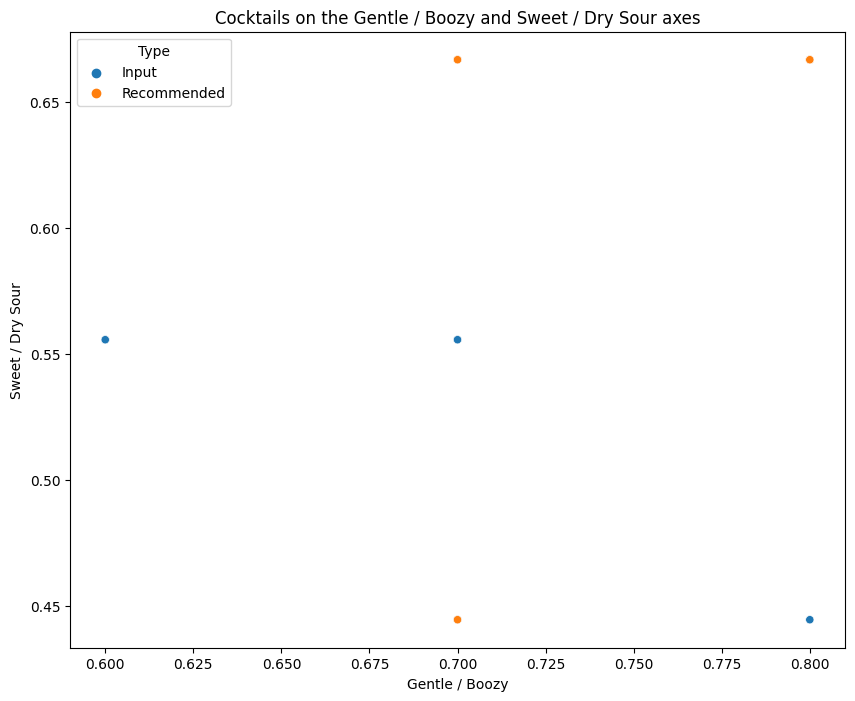

In [159]:
# Get feature values for input and recommended cocktails
input_cocktails_features = df_scaled.loc[cocktails_to_input_more, ["Gentle / Boozy", "Sweet / Dry Sour"]]
recommended_cocktails_features = df_scaled.loc[recommended_cocktails, ["Gentle / Boozy", "Sweet / Dry Sour"]]

# Create a new DataFrame for the plot
plot_df = pd.concat([input_cocktails_features, recommended_cocktails_features])
plot_df['Type'] = ['Input'] * len(cocktails_to_input_more) + ['Recommended'] * len(recommended_cocktails)

# Create the scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=plot_df, x='Gentle / Boozy', y='Sweet / Dry Sour', hue='Type')
plt.title('Cocktails on the Gentle / Boozy and Sweet / Dry Sour axes')
plt.show()

# Unsupervised Models

## VAE (Neural Network)

In [129]:
# Size of the latent space
latent_dim = 1024  # or set it to any other number you want

# Encoder
inputs = Input(shape=(df_scaled.shape[1], ))
encoded = Dense(256, activation='relu')(inputs)
z_mean = Dense(latent_dim)(encoded)
z_log_var = Dense(latent_dim)(encoded)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_inputs = Input(shape=(latent_dim,))
decoder_layer = Dense(256, activation='relu')(decoder_inputs)
decoder_outputs = Dense(df_scaled.shape[1], activation='sigmoid')(decoder_layer)
decoder = Model(decoder_inputs, decoder_outputs)

# VAE Model
outputs = decoder(z)
vae = Model(inputs, outputs)

# VAE Loss
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= df_scaled.shape[1]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Compile and fit model
vae.compile(optimizer='adam')
vae.fit(df_scaled, df_scaled, epochs=500, batch_size=32, validation_split=0.2, verbose=0)

# Make a Model to project inputs on the latent space
encoder = Model(inputs, z_mean)

# Project the df_scaled on the latent space
df_encoded = encoder.predict(df_scaled)

# Fit the NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(df_encoded)

# Define a function to get the most similar cocktails
def recommend_cocktails(cocktails, nbrs):
    valid_cocktails = [cocktail for cocktail in cocktails if cocktail in df_scaled.index]
    if not valid_cocktails:
        print('None of the cocktails are found.')
        return []
    
    # get the indices of the valid cocktails in df_scaled
    indices = [df_scaled.index.get_loc(cocktail) for cocktail in valid_cocktails]
    
    # average the latent representations of the valid cocktails
    avg_representation = df_encoded[indices].mean(axis=0).reshape(1, -1)

    # find the nearest neighbors of the averaged representation
    distances, indices = nbrs.kneighbors(avg_representation)
    
    recommended_cocktails = df_scaled.index[indices[0]].tolist()
    # excluding the cocktails that are in the input
    recommended_cocktails = [cocktail for cocktail in recommended_cocktails if cocktail not in valid_cocktails]
    
    if not recommended_cocktails:
        print('Not enough unique cocktails for recommendation.')
        return []
    
    return recommended_cocktails[:5]

# Get recommendations
recommended_cocktails = recommend_cocktails(cocktails_to_input, nbrs)
print(f"For {cocktails_to_input}, recommended cocktails are: ")
print(recommended_cocktails)


38/38 [==============================] - 0s 5ms/step
For ['Abbey', 'Hot Tub', 'The Frank', 'Green Ghost', 'Honey Cosmopolitan'], recommended cocktails are: 
['Gimlet (no added sugar & low-calorie)', 'Cazador', 'Three of Strong', 'The Prospector', "Green Isaac's Special"]


In [130]:
# get the weights from the first layer
weights_first_layer = vae.layers[1].get_weights()[0]

# sum the absolute values of the weights
weights_sum = numpy.sum(numpy.abs(weights_first_layer), axis=1)

# get feature importance
feature_importance = pd.Series(weights_sum, index=df.columns)

# print the top 10 important features
print(feature_importance.nlargest(20))


Calories                                               15.847704
Popularity                                             15.823647
Ratio_Punt E Mes or other full-bodied vermouth         15.781950
Ratio_Oloroso sherry                                   14.796051
Ratio_Peychaud's or other Creole-style bitters         14.734274
Ratio_Ginger liqueur                                   14.649063
Ratio_Kirschwasser (cherry) eau-de-vie                 14.590112
Ratio_Green Chartreuse liqueur                         14.535753
Content_Green Chartreuse liqueur                       14.501050
Content_Crème de violette liqueur                      14.476987
Content_Difford's Falernum liqueur                     14.443088
Ratio_Sauvignon blanc wine                             14.428352
Ratio_Fino sherry                                      14.416218
Category_After dinner/digestif                         14.400829
Ratio_Pallini Limoncello liqueur                       14.331768
Content_Fino sherry      

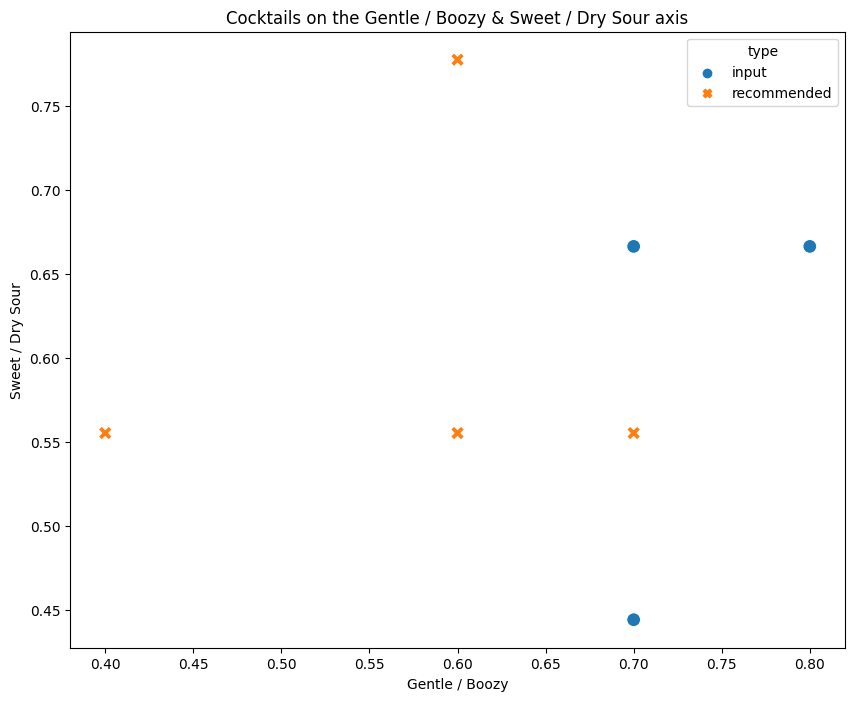

In [131]:
# Generate your cocktails_to_input and recommended_cocktails
recommended_cocktails_vae = recommend_cocktails(cocktails_to_input, nbrs)

# Concatenate the input cocktails and recommended cocktails
cocktail_list_vae = cocktails_to_input + recommended_cocktails_vae

# Select the cocktails in the cocktail list
df_plot_vae = df_scaled.loc[cocktail_list_vae]

# Create two new columns for the axes you're interested in
df_plot_vae['Gentle / Boozy'] = df_plot_vae['Gentle / Boozy']  # replace with the actual column name
df_plot_vae['Sweet / Dry Sour'] = df_plot_vae['Sweet / Dry Sour']  # replace with the actual column name

# Create a new column 'type' that labels whether the cocktail is an input or a recommendation
df_plot_vae['type'] = df_plot_vae.index.map(lambda x: 'input' if x in cocktails_to_input else 'recommended')

# Plot the cocktails on the Gentle / Boozy & Sweet / Dry Sour axis
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_plot_vae, x='Gentle / Boozy', y='Sweet / Dry Sour', hue='type', style='type', s=100)
plt.title('Cocktails on the Gentle / Boozy & Sweet / Dry Sour axis')
plt.show()


In [132]:
plot_model(vae, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


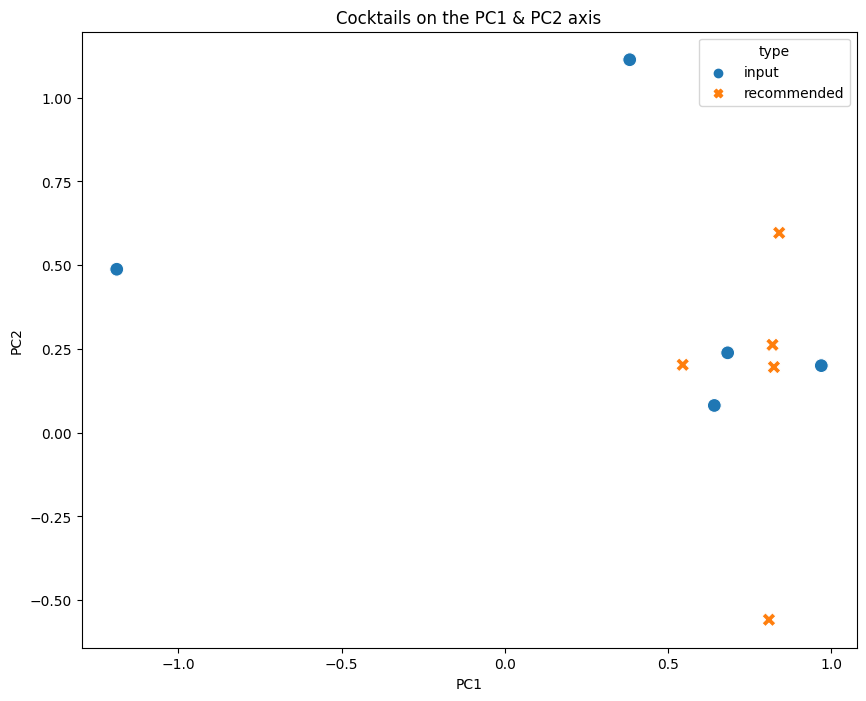

In [133]:
# Compute PCA
pca = PCA(n_components=2)  # We are only interested in the first two principal components
pca_result = pca.fit_transform(df_scaled)

# Create a DataFrame from PCA results
df_pca = pd.DataFrame(pca_result, index=df_scaled.index, columns=['PC1', 'PC2'])

# Concatenate the input cocktails and recommended cocktails
cocktail_list = cocktails_to_input + recommended_cocktails

# Select the cocktails in the cocktail list
df_plot = df_pca.loc[cocktail_list]

# Create a new column 'type' that labels whether the cocktail is an input or a recommendation
df_plot['type'] = df_plot.index.map(lambda x: 'input' if x in cocktails_to_input else 'recommended')

# Plot the cocktails on the PC1 & PC2 axis
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='type', style='type', s=100)
plt.title('Cocktails on the PC1 & PC2 axis')
plt.show()

## Cosine Similarity (KNN)

In [134]:
# Calculate cosine similarities
cos_sim = cosine_similarity(df_scaled)

# Create a DataFrame from the cosine similarities
cos_sim_df = pd.DataFrame(cos_sim, index=df_scaled.index, columns=df_scaled.index)

# Fit the NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=5, metric='cosine').fit(df_scaled)

def recommend_cocktails(cocktails, nbrs):
    recommendations = []
    for cocktail in cocktails:
        if cocktail in df_scaled.index:
            distances, indices = nbrs.kneighbors(df_scaled.loc[[cocktail]])
            recommendations += df_scaled.index[indices[0]].tolist()[1:]  # excluding the first one because it will be the same cocktail
        else:
            print('Cocktail not found.')
    return recommendations
    
# Get the recommendations
recommended_cocktails = recommend_cocktails(cocktails_to_input, nbrs)
print(recommended_cocktails)


['Blue Star', 'Income Tax Cocktail', 'Houla Houla Cocktail', 'Fibber McGee', 'Twinkle', 'King of Orange', 'Transylvanian Martini', 'Very French Martini', 'Mr President', 'Valentino', 'Celebration', 'Violet Affinity', 'London Cocktail', 'Mujer Verde', 'London Fog', "Gimlet Cocktail (Difford's recipe)", 'The Flirt', 'Lolita Margarita', 'Pink Grapefruit Margarita', 'Tailor Made']


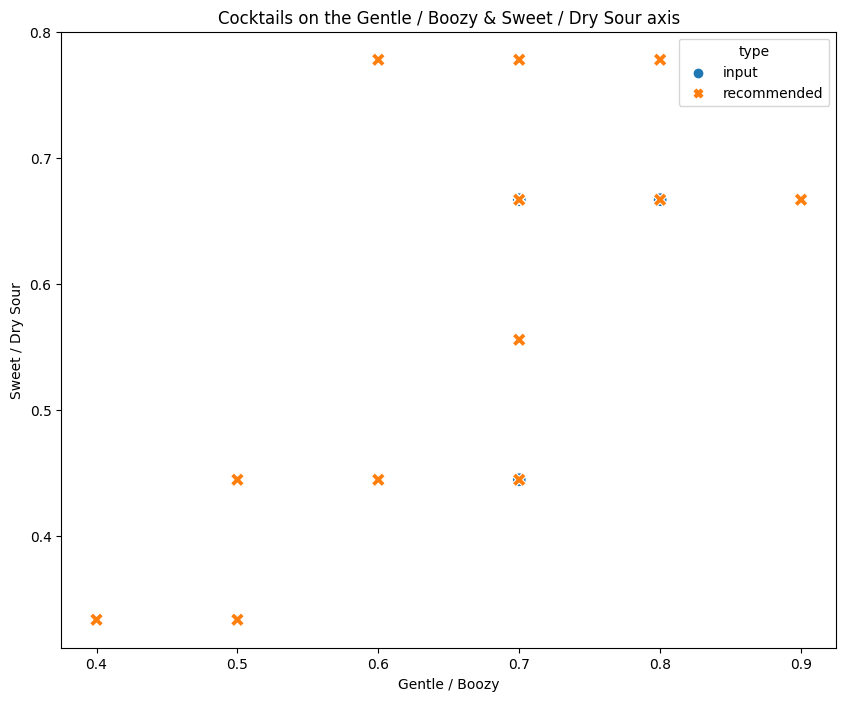

In [135]:
# Concatenate the input cocktails and recommended cocktails
cocktail_list = cocktails_to_input + recommended_cocktails

# Select the cocktails in the cocktail list
df_plot = df_scaled.loc[cocktail_list]

# Create two new columns for the axes you're interested in
df_plot['Gentle / Boozy'] = df_plot['Gentle / Boozy']  # replace with the actual column name
df_plot['Sweet / Dry Sour'] = df_plot['Sweet / Dry Sour']  # replace with the actual column name

# Create a new column 'type' that labels whether the cocktail is an input or a recommendation
df_plot['type'] = df_plot.index.map(lambda x: 'input' if x in cocktails_to_input else 'recommended')

# Plot the cocktails on the Gentle / Boozy & Sweet / Dry Sour axis
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_plot, x='Gentle / Boozy', y='Sweet / Dry Sour', hue='type', style='type', s=100)
plt.title('Cocktails on the Gentle / Boozy & Sweet / Dry Sour axis')
plt.show()
